# Introduction

*This notebook first appeared as a part of [forests-intro](https://github.com/wildtreetech/forests-intro).*

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0; display: inline" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Forests intro</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="https://github.com/wildtreetech/forests-intro" property="cc:attributionName" rel="cc:attributionURL">Tim Head</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

*Feel free to use, distribute, and modify with the above attribution.*

# Tim is:

Grew up in Germany, then worked at CERN and EPFL, now data science consulting and training.

# Today's programme

Talk about supervised classification.

* trees and forests, robust estimators for the 99%
* pushing all the buttons, how to select and validate hyper-parameters
* should I stay or should I go, putting it all together to predict mobile phone customer churn

(Regression and unsupervised methods another time.)

# Machine learning

Historical data can be used to "learn" a model of
complex processes. Once this model has been learnt from
historical data it can be applied to new data for which
the outcome is not yet known. We make predictions.

Hello world example:

> For example using today's air temperature, precipitation,
> wind speed and wind direction we could predict whether or
> not it will rain tomorrow (classification) or what the temperature (regression) will be.

# Applications

* email classification: spam or ham?
* tagging documents
* stock market predictions
* is this project likely to over-/underspend?
* will this piece of equipment break soon?
* finding the Higgs boson at CERN
* recognising cats in pictures
* identifying body parts with Kinect cameras

# Python for data analysis

- The __open source__ Python ecosystem provides __a standalone, versatile and powerful scientific working environment__, including: [NumPy](http://numpy.org), [SciPy](http://scipy.org), [Jupyter](http://jupyter.org), [Matplotlib](http://matplotlib.org), [Pandas](http://pandas.pydata.org/), _and many others..._

<center> 
<img src="img/scikit-learn-logo.png" style="max-width: 120px; display: inline" />
<img src="img/numpy-logo.png" style="max-width: 120px; display: inline" />
<img src="img/scipy-logo.png" style="max-width: 120px; display: inline" />
<img src="img/jupyter-logo.png" style="max-width: 100px; display: inline" />
<img src="img/matplotlib-logo.png" style="max-width: 120px; display: inline"/>
<img src="img/pandas-logo.png" style="max-width: 120px; display: inline" />
</center>

# Scikit-learn

Today's tool of choice!

* Machine learning library written in __Python__
* __Simple and efficient__, for both experts and __non-experts__
* Classical, __well-established machine learning algorithms__
* Shipped with <a href="http://scikit-learn.org/dev/documentation.html">documentation</a> and <a href="http://scikit-learn.org/dev/auto_examples/index.html">examples</a>
* __BSD 3 license__
* Community driven development
 - 20~ core developers (mostly researchers)
 - 500+ occasional contributors
 - __All working publicly together__ on [GitHub](https://github.com/scikit-learn/scikit-learn)
 - Emphasis on __keeping the project maintainable__

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Let's start with some blobs

In [2]:
# Generate more complicated data
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=20, random_state=42)
labels = ["b", "r"]
y = np.take(labels, (y < 10))

Data is stored in `X` and the labels in `y`. Each row of `X` is one sample. Each feature
is represented by a column:

In [3]:
print(X[:5,:])
print()
print(y[:5])

[[ 4.20578296 -0.55173454]
 [ 2.31387979 -8.49311501]
 [-3.54648183  0.10178982]
 [ 3.44857534  2.62972329]
 [-9.09072629  8.05530056]]

['b' 'b' 'r' 'r' 'b']


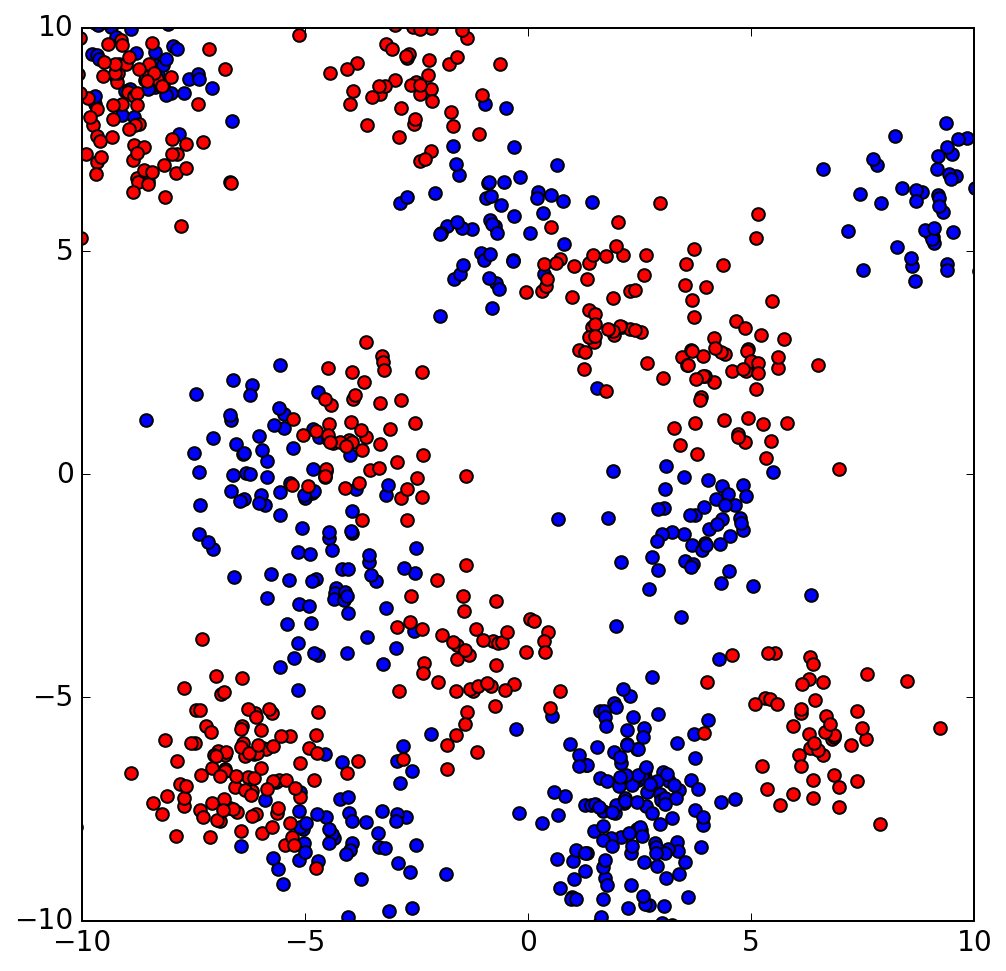

In [4]:
plt.figure()
for label in labels:
    mask = (y == label)
    plt.scatter(X[mask, 0], X[mask, 1], c=label, s=40)
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.show()

# Decision trees

`scikit-learn` implements many different classifiers. Each with
its own strengths and weaknesses. They all follow the same interface
which makes it simple to change and explore different options.

```python
class MyClassifier:
  def fit(self, X, y):
    # learn from the data
  def predict(self, X):
    # make predictions for unseen data
```

Take a look at the documentation, it is excellent.

Today we will focus on decision trees and related models. They
are amongst the best general purpose estimators. They are
robust and flexible when it comes to weird things in your
input data, can handle mixtures of data types, and are
conceptually easy to understand.

<img src="img/tree-simple.png" style="max-width: 500px;"/>
<img src="img/tree-partition.png" style="max-width: 300px;"/>

In [5]:
# Import the decision tree class
from sklearn.tree import DecisionTreeClassifier 

# Set hyper-parameters, to control the algorithms behaviour
# Let's experiment a bit
clf = DecisionTreeClassifier(min_samples_leaf=10)

# Learn a model from the training data
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

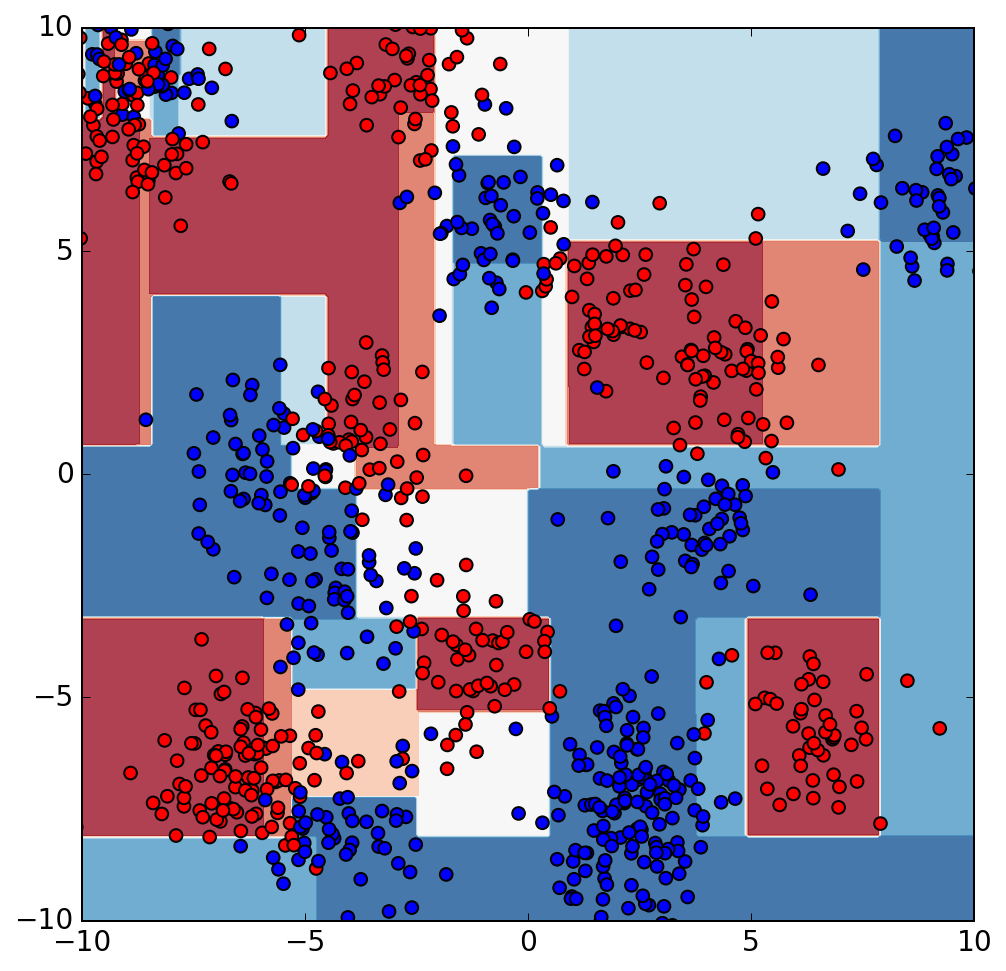

In [6]:
from utils import plot_surface

plot_surface(clf, X, y)

In [7]:
from utils import draw_tree

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)
draw_tree(clf, ['X1', 'X2'], filled=True)

# Forests

A single decision tree is nice, however limited in its performance. Similar to the "wisdom
of crowds" a technique that works very well is combining lots of individual decision
trees into a **forest**.

> At a 1906 country fair in Plymouth, 800 people participated in a contest to estimate the
> weight of a slaughtered and dressed ox. Statistician Francis Galton observed that
> the median guess, 1207 pounds, was accurate within 1% of the true weight of 1198 pounds.

Concretely we will use a **random forest**. Split your data into random sub-samples and 
construct a decision tree on each part. Then take the average all trees as the
output of the random forest.

<img src="img/forest.png" style="max-width: 500px;"/>

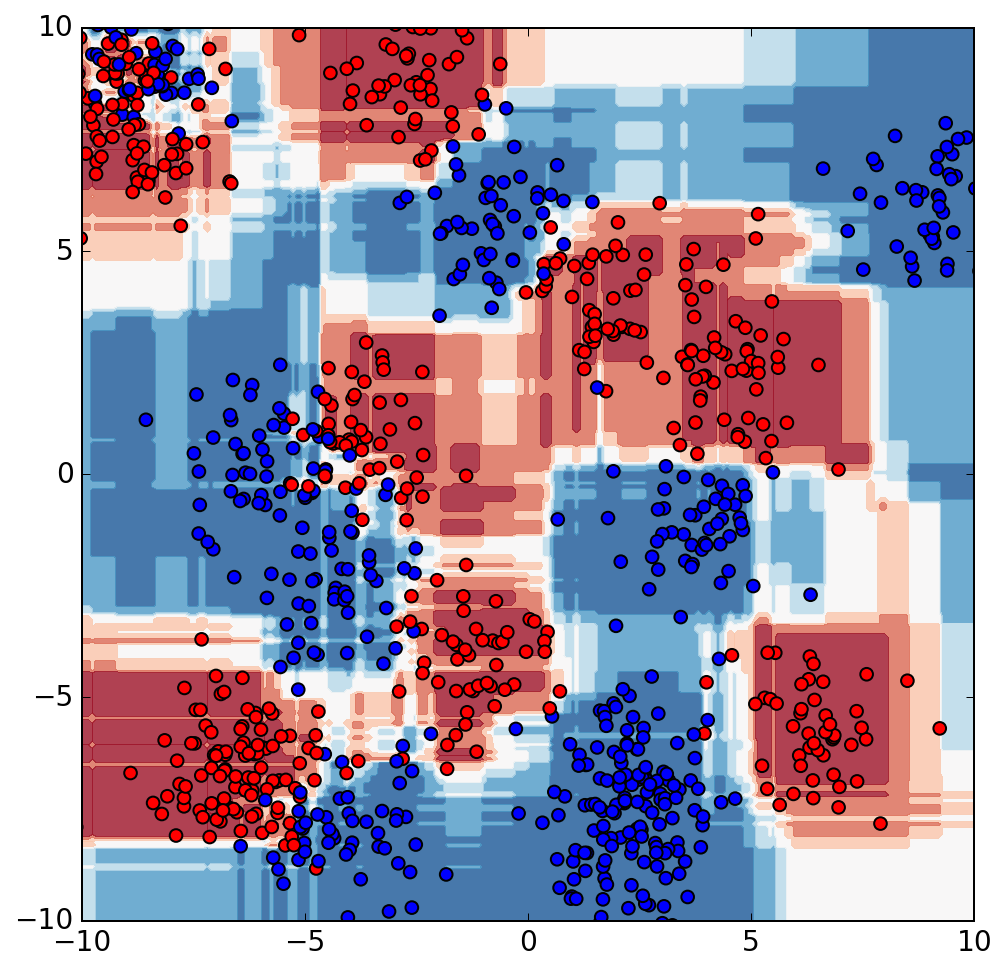

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=10).fit(X, y)
plot_surface(clf, X, y)

In [9]:
# Questions? -> Answers!
#RandomForestClassifier?

# Things to remember

* Machine learning: automatically find patterns in historical data to make predictions on new, unseen data
* finds patterns you can find, but also works when it gets complicated or more than
  two dimensions
* state of the art tools are being maintained by a community of experts, maximum freedom
* Decision tree based models are easy to use, robust and perform well